For this notebook you will need the file `notebooks\BERT\utils\count_class_py`. In this file all the function with there descriptions are available.

In [7]:
%load_ext autoreload
%autoreload 2

INF = 1e30

import os
from os import path


# set the repository to the git repository
cwd = os.getcwd().split(os.path.sep)
while cwd[-1] != "AttentionGeometry":
    os.chdir("..")
    cwd = os.getcwd().split(os.path.sep)
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_theme()
sns.color_palette("flare", as_cmap=True)
from tqdm.notebook import tqdm

# from the environment
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from src.bert_model import BertNliRegu
from src.bert_data_module.esnli import ESNLIDataModule
import tikzplotlib

# specific file for this notebook
from notebooks.BERT.utils.count_class import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We will provide this work for our different datasets

- ESNLI

# E-SNLI

## FT -- version

In [8]:
# load data and model
data_dir = os.path.join(".cache_bert", "datasets", "EsnliDataSet")

dm = ESNLIDataModule(cache=data_dir,
                   batch_size = 4,
                   num_workers = 4,
                   nb_data = -1
                   )

dm.prepare_data()

dm.setup(stage="test")

test_dataset = dm.test_set
test_dataloader = dm.test_dataloader()

ckp = path.join(".cache_bert", "logs", "snli_igrida_trained", "0", "best.ckpt")
model = BertNliRegu.load_from_checkpoint(ckp)
model = model.to(DEVICE)
model = model.eval()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
C:\Users\loicf\miniconda3\envs\nlp\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions

>> Searching the rep
>> rep found !
>> start the loop
>> all done !


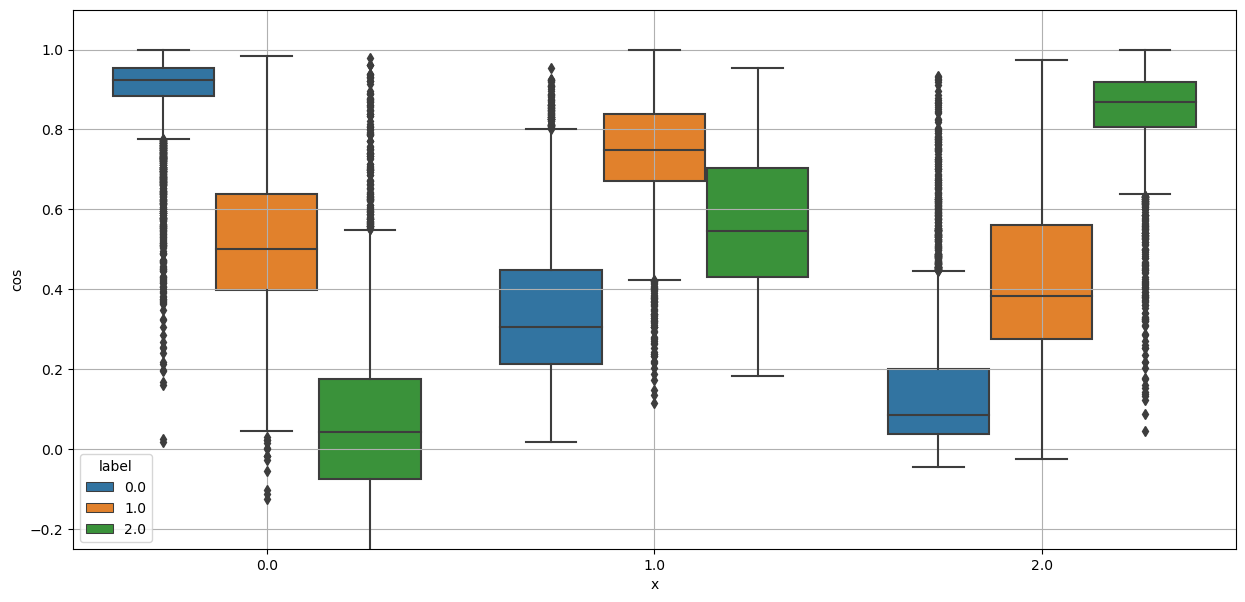

In [10]:
res, rep, pred = main(model, dm, dm.nb_data, dm.batch_size)

x = np.concatenate((np.zeros(res.shape[0]), np.ones(res.shape[0]), 2*np.ones(res.shape[0])))
cos_values = np.concatenate((res["cos_class_0"].values, res["cos_class_1"].values, res["cos_class_2"].values))
labels = np.concatenate((res["label"], res["label"], res["label"]))
df = pd.DataFrame(
    {"x": x,
    "cos": cos_values,
    "label": labels,
    }
)
fig, axes = plt.subplots(1,1, figsize=(15, 7))
axes.set_ylim([-0.25, 1.1])
sns.boxplot(data=df, x="x", y="cos", hue="label", ax=axes)
tikzplotlib.save((os.path.join(".cache_bert", "plots", "paper", "cone_class_esnli_ft.tex")))
axes.grid()
plt.savefig(os.path.join(".cache_bert", "plots", "paper", "cone_class_esnli_ft.png"))

In [19]:
pred = np.array(pred)

In [20]:
pred = np.array(pred)
acc_res = []
for c in [0, 1, 2]:
    mask = res["label"]==c
    p = pred[mask]
    
    acc_res.append(np.mean((p==c)*1))
      

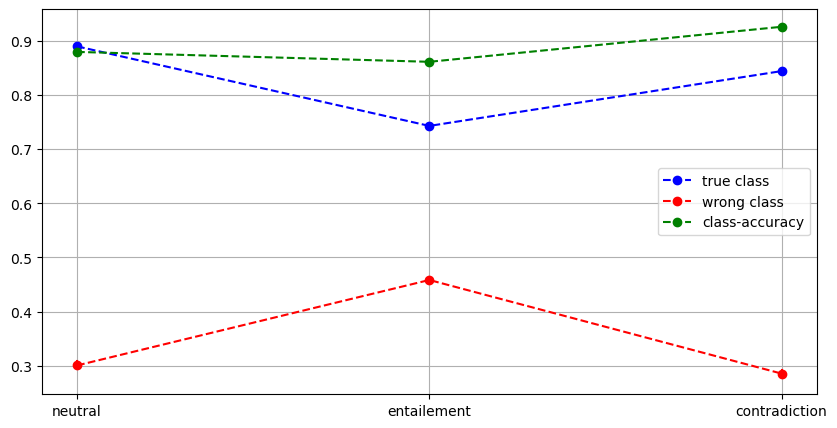

In [21]:
x = [0, 1, 2]
y1 = []
s1 = []

y2 = []
s2 = []

rep_class = np.array(df["x"])
label = np.array(df["label"])

for l in x:
    mask = rep_class==l
    cos_values = df["cos"][mask]
    
    # good rep labels
    mask_2 = label[mask]==l
    
    cos_temp = cos_values[mask_2]
    y1.append(cos_temp.mean())
    s1.append(2 * cos_temp.std()/np.sqrt(len(cos_temp)))
    
    
    cos_temp = cos_values[~mask_2]
    y2.append(cos_temp.mean())
    s2.append(2 * cos_temp.std()/np.sqrt(len(cos_temp)))
    
    
y1 = np.array(y1)
dev1 = np.array(s1)
y2 = np.array(y2)
dev2 = np.array(s2)  


figure, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.plot(x, y1, "o--", label="true class", color="blue")
ci_inf = y1-dev1
ci_sup = y1+dev1
for i, l in enumerate(x):
    ax.plot([l, l], [ci_inf[i], ci_sup[i]], color="blue")


ax.plot(x, y2, "o--", label="wrong class", color="red")
ci_inf = y2-dev2
ci_sup = y2+dev2
for i, l in enumerate(x):
    ax.plot([l, l], [ci_inf[i], ci_sup[i]], color="red")

ax.plot(x, acc_res, "o--", label="class-accuracy", color="green")
ax.legend()
ax.set_xticks(list(range(3)))
ax.set_xticklabels(["neutral", "entailement", "contradiction"])
ax.grid()
plt.savefig(os.path.join(".cache_bert", "plots", "paper", "e-snli.png"))

C:\Users\loicf\miniconda3\envs\nlp\lib\site-packages\matplotlib\cbook\__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
C:\Users\loicf\miniconda3\envs\nlp\lib\site-packages\matplotlib\cbook\__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


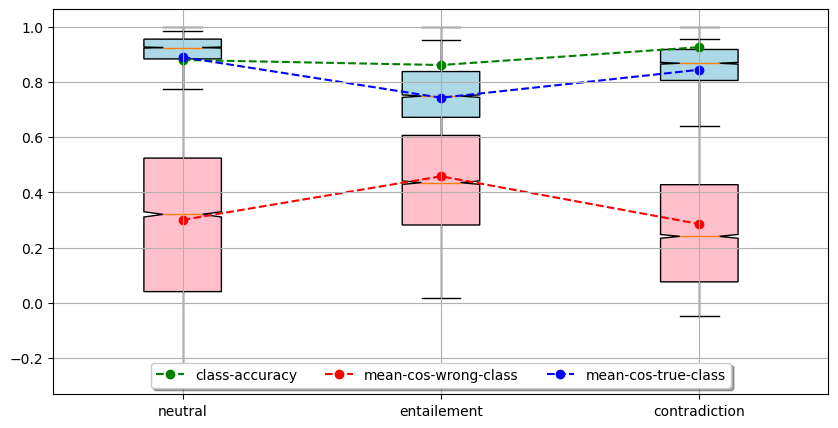

In [25]:
x = [0, 1, 2]
data1 = []
data2 = []

rep_class = np.array(df["x"])
label = np.array(df["label"])

for l in x:
    mask = rep_class==l
    cos_values = df["cos"][mask]
    
    # good rep labels
    mask_2 = label[mask]==l
    
    cos_temp = cos_values[mask_2]
    data1.append(cos_temp)
    
    
    cos_temp = cos_values[~mask_2]
    data2.append(cos_temp)
    
    
y1 = np.array(y1)
dev1 = np.array(s1)
y2 = np.array(y2)
dev2 = np.array(s2)  


figure, ax = plt.subplots(1, 1, figsize=(10, 5))
bplot1 = ax.boxplot(data1, showfliers=False, patch_artist=True, notch=True, zorder=-1)
bplot2 = ax.boxplot(data2, showfliers=False, patch_artist=True, notch=True, zorder=-1)
for patch in bplot1['boxes']:
    patch.set_facecolor("lightblue")
    
for patch in bplot2['boxes']:
    patch.set_facecolor("pink")

ax.plot(np.array(x)+1, acc_res, "o--", label="class-accuracy", color="green", zorder=1)
ax.plot(np.array(x)+1, y2, "o--", label="mean-cos-wrong-class", color="red", zorder=1)
ax.plot(np.array(x)+1, y1, "o--", label="mean-cos-true-class", color="blue", zorder=1)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 0.1),
          ncol=3, fancybox=True, shadow=True)
ax.set_xticks(list(range(1, 4)))
ax.set_xticklabels(["neutral", "entailement", "contradiction"])
ax.grid()
temp = ax.set(
    #xlabel="label-id"
)

plt.savefig(os.path.join(".cache_bert", "plots", "paper", "esnli-boxplot.png"))

On peut voir ici un détachement. On a une séparation des classes qui est très flagrante

In [5]:
model = model.cpu()
del model
torch.cuda.empty_cache()

## PT -- version

In [6]:
# load data and model
data_dir = os.path.join(".cache_bert", "datasets", "EsnliDataSet")

dm = ESNLIDataModule(cache=data_dir,
                   batch_size = 4,
                   num_workers = 4,
                   nb_data = 999
                   )

dm.prepare_data()

dm.setup(stage="test")

test_dataset = dm.test_set
test_dataloader = dm.test_dataloader()

model = BertNliRegu()
model = model.to(DEVICE)
model = model.eval()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
C:\Users\loicf\miniconda3\envs\nlp\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions

>> Re-use the rep
>> rep found !
>> start the loop
>> all done !


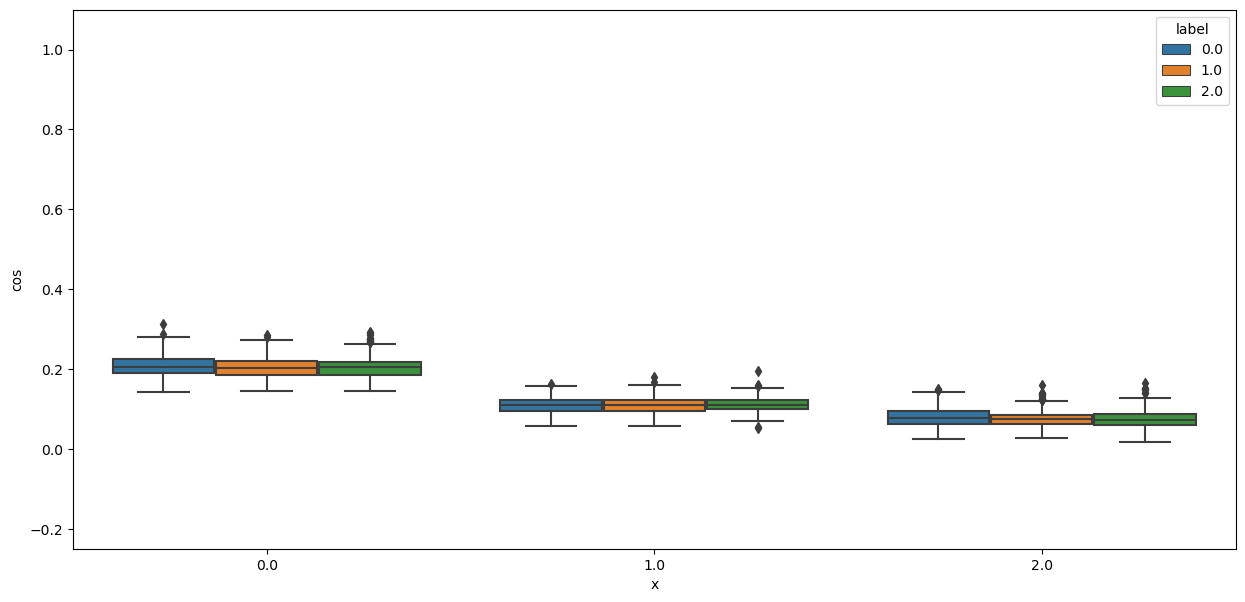

In [7]:
res, rep = main(model, dm, dm.nb_data, dm.batch_size, ft=False, representative=rep)

x = np.concatenate((np.zeros(res.shape[0]), np.ones(res.shape[0]), 2*np.ones(res.shape[0])))
cos_values = np.concatenate((res["cos_class_0"].values, res["cos_class_1"].values, res["cos_class_2"].values))
labels = np.concatenate((res["label"], res["label"], res["label"]))
df = pd.DataFrame(
    {"x": x,
    "cos": cos_values,
    "label": labels,
    }
)
fig, axes = plt.subplots(1,1, figsize=(15, 7))
axes.set_ylim([-0.25, 1.1])
sns.boxplot(data=df, x="x", y="cos", hue="label", ax=axes)

plt.savefig(os.path.join(".cache_bert", "plots", "paper", "cone_class_esnli_pt.png"))

Ici nous n'observons aucune séparation des classes en terme de direction.

In [7]:
model = model.cpu()
del model
torch.cuda.empty_cache()